# Vanguard Portfolio Optimizer

## Initialization

In [1]:
%matplotlib inline

In [78]:
import json
import typing

import cvxpy as cp
import inflection
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import requests_cache
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
requests_cache.install_cache("requests_cache", backend="sqlite")

In [120]:
PRODUCT_URL = "https://www.vanguardinvestor.co.uk/api/productList"
REQUEST_URL = "https://api.vanguard.com/rs/gre/gra/1.7.0/datasets/urd-product-port-specific-price-history.json?vars=portId:{port_id},issueType:S,startDate:{start_date:%Y-%m-%d},endDate:{end_date:%Y-%m-%d}"
ASSET_COLOURS = {"bond": "red", "equity": "green"}
CUTOFF_YEAR = 2017

START_DATE = pd.to_datetime("2021-01-01")
END_DATE = pd.to_datetime("2023-12-31")

## Get products descriptions

In [5]:
def get_products() -> pd.DataFrame:
    request = requests.get(PRODUCT_URL)
    assert request.status_code == 200
    return json.loads(request.text)


def len_or(value, none_value=1) -> int:
    return none_value if value is None else len(value)


def parse_allocation(allocation):
    tokens = [a.removesuffix("%").split(" ") for a in allocation.split(",")]
    return {t[0].lower(): float(t[1]) for t in tokens if t[1] != "0"}


def products_json_to_df(products_json) -> pd.DataFrame:
    return (
        pd.DataFrame(products_json)
        .assign(
            fees=lambda x: x["ocfValue"],
            allocation=lambda x: x["allocation"].apply(parse_allocation),
            assets=lambda x: x["allocation"].apply(len_or),
            inceptionDate=lambda x: pd.to_datetime(x["inceptionDate"]),
        )
        .reset_index(drop=True)
    )

In [89]:
raw_products = get_products()
raw_products_df = products_json_to_df(raw_products).rename(
    columns=inflection.underscore
)

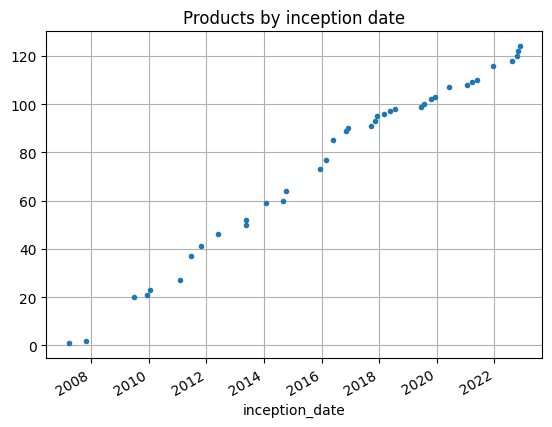

In [92]:
ax = (
    raw_products_df.groupby("inception_date")
    .size()
    .sort_index()
    .cumsum()
    .plot(grid=True, style=".")
)
_ = ax.set_title("Products by inception date")

## Filter products

* Keep only "Accumulation" products (their dividends are automatically reinvsted)
* Remove actively managed products
* Remove ESG/SRI products (they are highly correlated to the non ESG/SRI products)
* Remove recently created products (not enough historical data)

In [94]:
products_df = raw_products_df[
    lambda x: (x["share_class"] == "Accumulation")
    & x["asset_class"].isin(["bond", "equity"])
    & (x["management_type"] == "Index")
    & ~x["esg_type"].str.startswith("esg")
    & (x["inception_date"].dt.year <= CUTOFF_YEAR)
].reset_index(drop=True)

In [95]:
products_df[["name", "fees", "inception_date"]].sort_values("fees", ignore_index=True)

,name,fees,inception_date
0,FTSE 100 Index Unit Trust,0.06,2016-11-08
1,FTSE U.K. All Share Index Unit Trust,0.06,2009-12-04
2,U.S. Equity Index Fund,0.10,2009-06-23
3,U.K. Investment Grade Bond Index Fund,0.12,2007-03-20
4,U.K. Government Bond Index Fund,0.12,2009-06-23
5,FTSE Developed Europe ex-U.K. Equity Index Fund,0.12,2009-06-23
6,U.K. Long Duration Gilt Index Fund,0.12,2011-02-03
7,U.K. Inflation-Linked Gilt Index Fund,0.12,2011-02-03
8,U.K. Short-Term Investment Grade Bond Index Fund,0.12,2013-05-22
9,FTSE U.K. Equity Income Index Fund,0.14,2009-06-23


## Get products historical prices

In [86]:
QUERY = "query PriceDetailsQuery($portIds: [String!]!, $startDate: String!, $endDate: String!, $limit: Float) {  funds(portIds: $portIds) {    pricingDetails {      navPrices(startDate: $startDate, endDate: $endDate, limit: $limit) {        items {          price          asOfDate          currencyCode          __typename        }        __typename      }      marketPrices(startDate: $startDate, endDate: $endDate, limit: $limit) {        items {          portId          items {            price            asOfDate            currencyCode            __typename          }          __typename        }        __typename      }      __typename    }    __typename  }}"
PAYLOAD_RAW = {
    "operationName": "PriceDetailsQuery",
    "variables": {
        "portIds": ["9140"],
        "startDate": START_DATE.strftime("Y%-%m-%d"),
        "endDate": END_DATE.strftime("%Y-%m-%d"),
        "limit": 0,
    },
    "query": QUERY,
}
URL = "https://www.vanguardinvestor.co.uk/gpx/graphql"

results = []

for port_id in products_df["portId"].tolist():
    PAYLOAD_RAW["variables"]["portIds"] = [str(port_id)]
    response = requests.post(
        URL, data=json.dumps(PAYLOAD_RAW), headers={"content-type": "application/json"}
    )
    assert response.status_code == 200
    histories[port_id] = json.loads(response.text)

In [99]:
def convert_history(payload) -> pd.DataFrame:
    return (
        pd.DataFrame(
            payload["data"]["funds"][0]["pricingDetails"]["navPrices"]["items"]
        )
        .rename(columns=inflection.underscore)
        .assign(as_of_date=lambda x: pd.to_datetime(x["as_of_date"]))
        .drop(columns=["__typename"])
    )


historical_df = pd.concat(
    [convert_history(value).assign(port_id=key) for key, value in histories.items()],
    ignore_index=True,
).sort_values("as_of_date", ignore_index=True)

## Explore products stats

In [149]:
port_id_to_name = products_df.set_index("port_id")["name"].to_dict()
pivoted_prices = historical_df.pivot(
    index=["as_of_date"], columns=["port_id"], values=["price"]
).ffill()

In [150]:
pivoted_returns = (
    pivoted_prices.pct_change()
    .droplevel(0, axis=1)
    .dropna(how="any")[lambda x: sorted(x.columns)]
)
pivoted_returns

port_id,8617,8619,9125,9140,9144,9146,9148,9156,9158,9206,9210,9214,9218,9222,9226,9247
as_of_date,,,,,,,,,,,,,,,,
2016-11-09,-0.002258,0.010044,-0.001861,-0.027552,-0.046853,-0.025769,-0.001949,0.009358,0.004870,0.007488,-0.002205,-0.001418,0.009694,-0.004103,0.000329,0.000017
2016-11-10,0.000057,-0.009642,-0.006311,-0.008708,0.036767,0.015620,-0.011674,-0.006938,0.004682,-0.010722,0.001623,-0.012912,-0.000429,-0.019422,-0.013570,-0.001224
2016-11-11,-0.012534,-0.014349,-0.002197,-0.038307,-0.005451,-0.009062,-0.000764,-0.013700,-0.003163,-0.009574,-0.010850,-0.014706,-0.006964,-0.000876,-0.002342,-0.000347
2016-11-14,0.008134,0.003397,-0.005452,-0.001497,0.008451,0.004861,-0.007202,0.003143,0.016020,0.002062,0.008011,-0.000961,0.012823,-0.012371,-0.011815,-0.000449
2016-11-15,0.011129,0.005860,0.005104,0.008357,0.004088,0.005336,0.008442,0.005762,0.009800,0.006808,0.011486,0.010721,0.012867,0.014966,0.011712,0.000865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,-0.002935,0.000465,0.001766,-0.010854,-0.002835,-0.001294,0.001929,-0.003786,0.001810,-0.001986,-0.002696,-0.001818,-0.002576,0.002395,0.003244,0.001085
2023-12-26,0.000000,0.000000,0.000401,0.007056,0.000619,0.001348,0.000297,0.000000,0.006857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000318
2023-12-27,0.003925,0.008371,0.002466,0.005676,0.007229,0.005502,0.004198,0.008407,-0.000370,0.007246,0.002131,0.005113,0.001034,0.006631,0.004161,0.005623


In [127]:
yearly_returns_mean = ((1 + pivoted_returns.mean()) ** 252 - 1).rename(
    "yearly_return_mean"
)
yearly_returns_std = (pivoted_returns.std() * np.sqrt(252)).rename("yearly_return_std")
counts = pivoted_returns.count().rename("count")

stats = pd.concat([yearly_returns_mean, yearly_returns_std, counts], axis=1)

In [128]:
products_stats_df = products_df.join(stats, on="port_id")

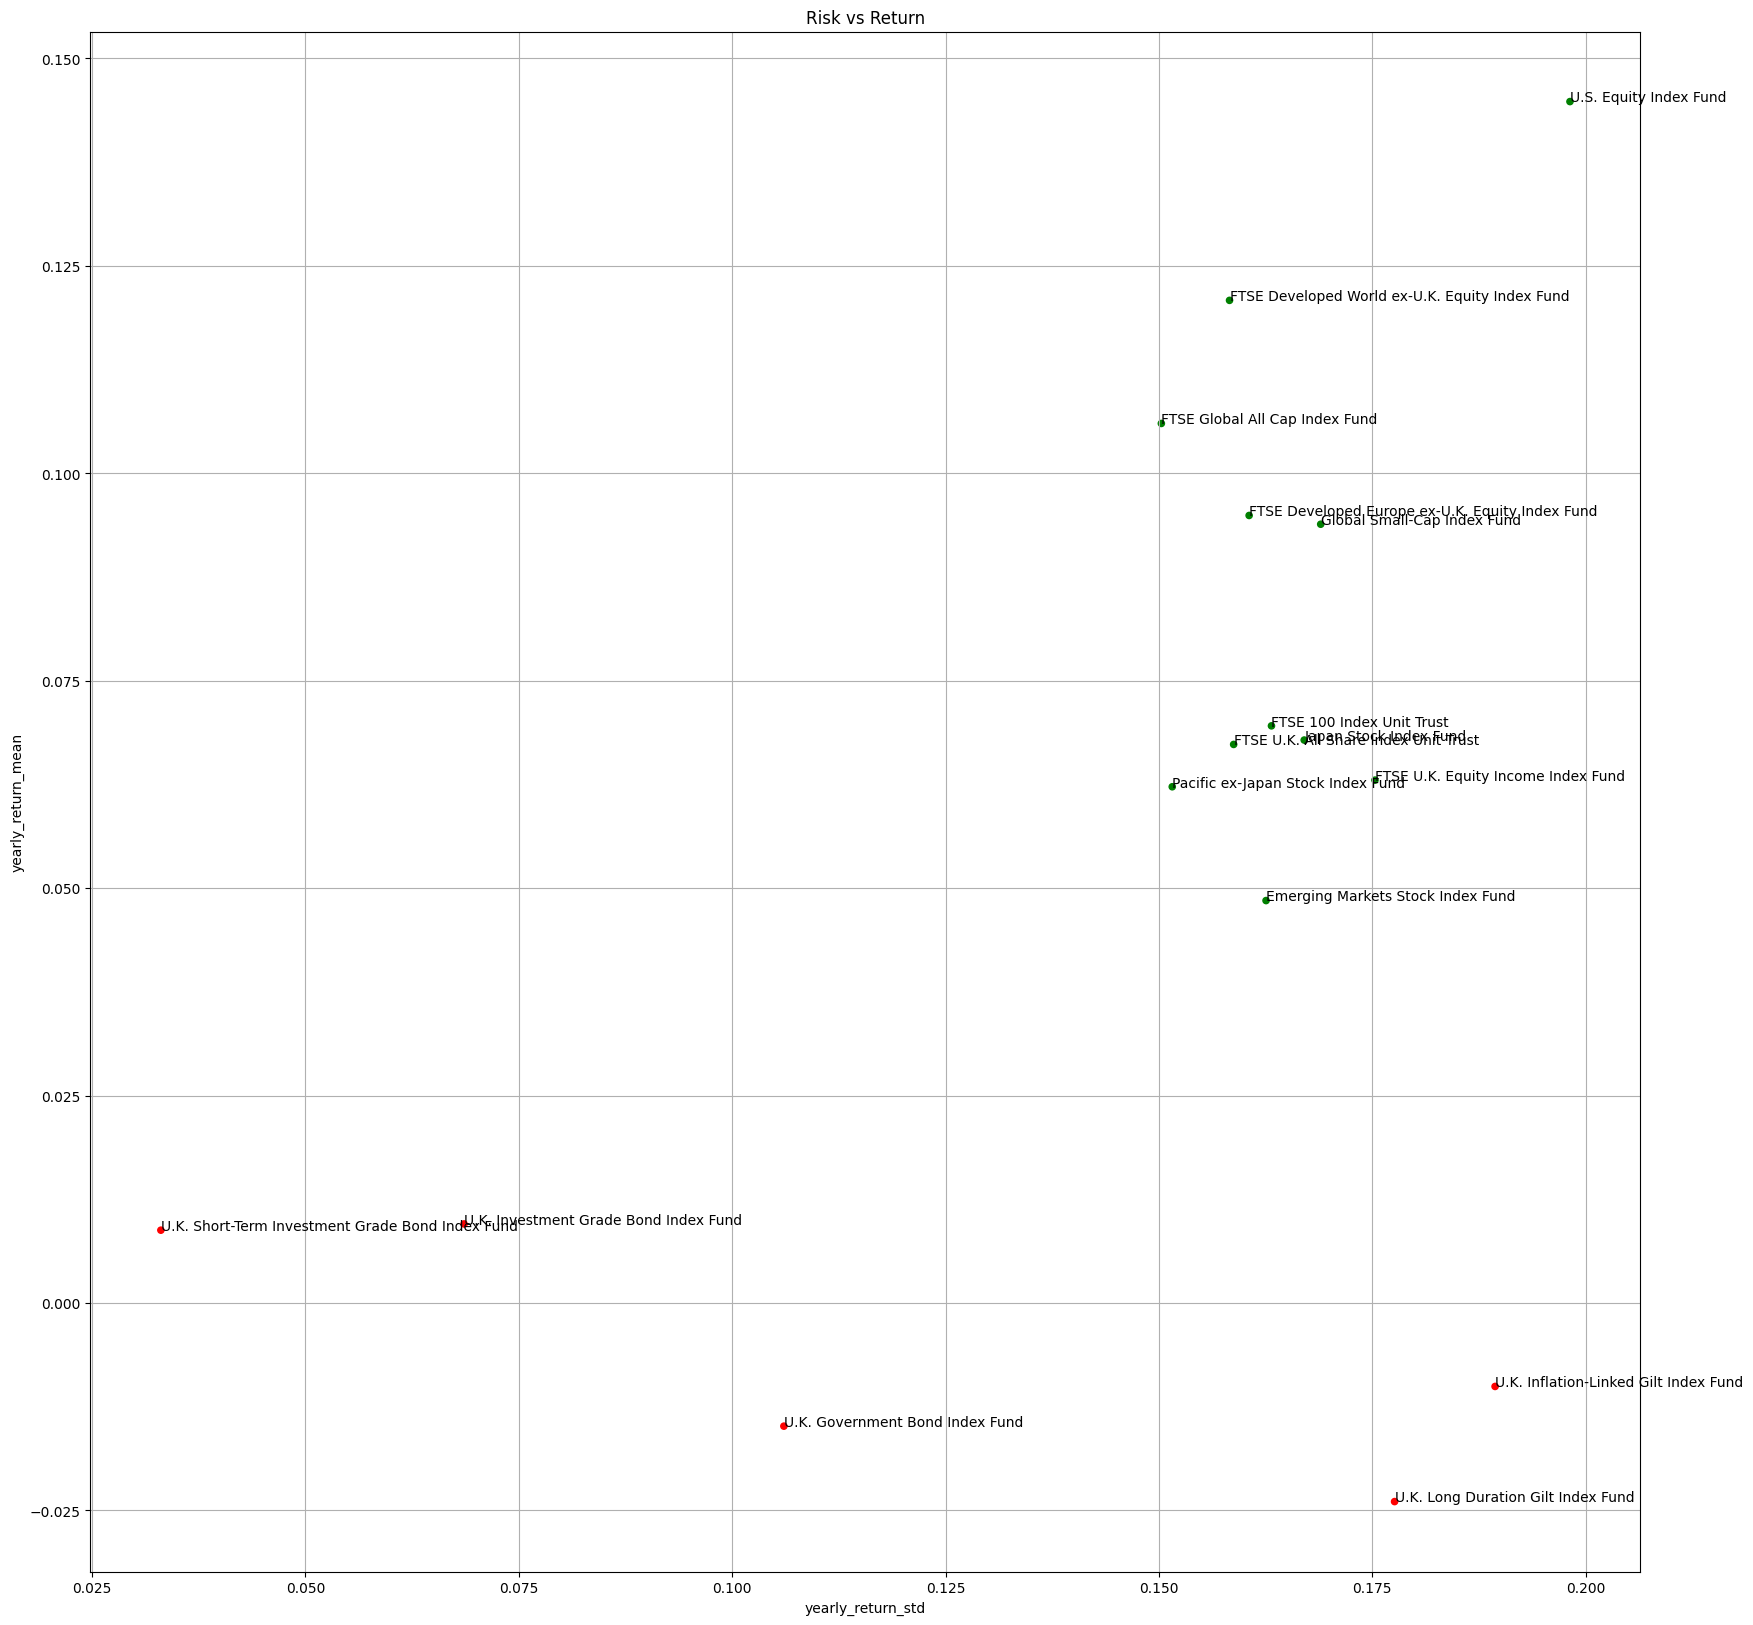

In [130]:
ax = (
    products_stats_df
    # .set_index('year_std')
    .plot.scatter(
        x="yearly_return_std",
        y="yearly_return_mean",
        grid=True,
        figsize=(20, 20),
        c=products_stats_df["asset_class"].map(ASSET_COLOURS),
    )
)


def label_point(x, y, val, ax):
    a = pd.concat({"x": x, "y": y, "val": val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point["x"], point["y"], str(point["val"]))


label_point(
    products_stats_df["yearly_return_std"],
    products_stats_df["yearly_return_mean"],
    products_stats_df["name"],
    ax,
)
_ = ax.set_title("Risk vs Return")

In [133]:
sorted_port_id = (
    pivoted_prices.div(pivoted_prices.iloc[0], axis=1)
    .iloc[-1]
    .sort_values(ascending=False)
    .index
)

<Axes: title={'center': 'Historical prices'}, xlabel='as_of_date'>

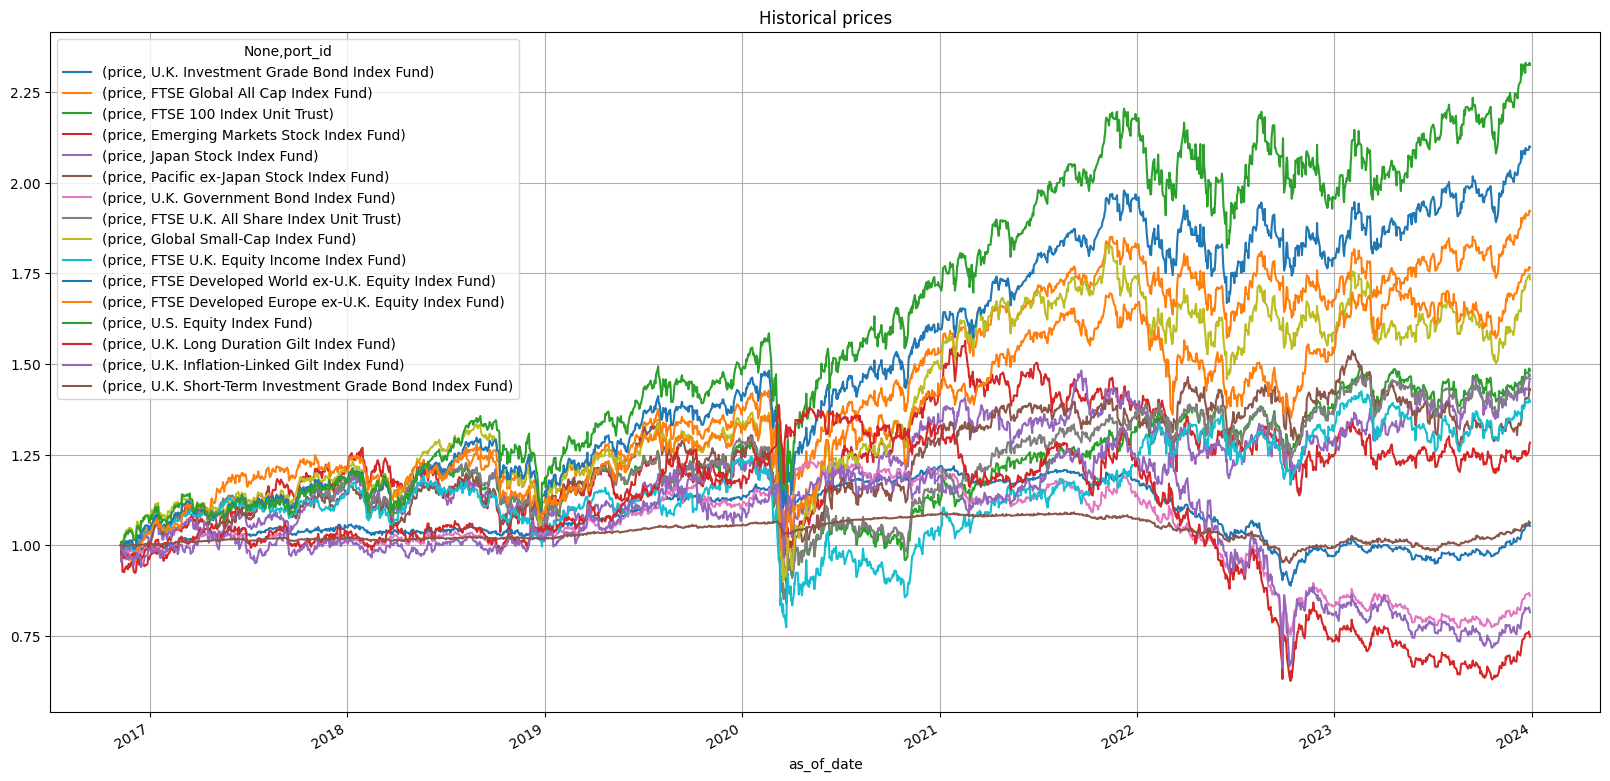

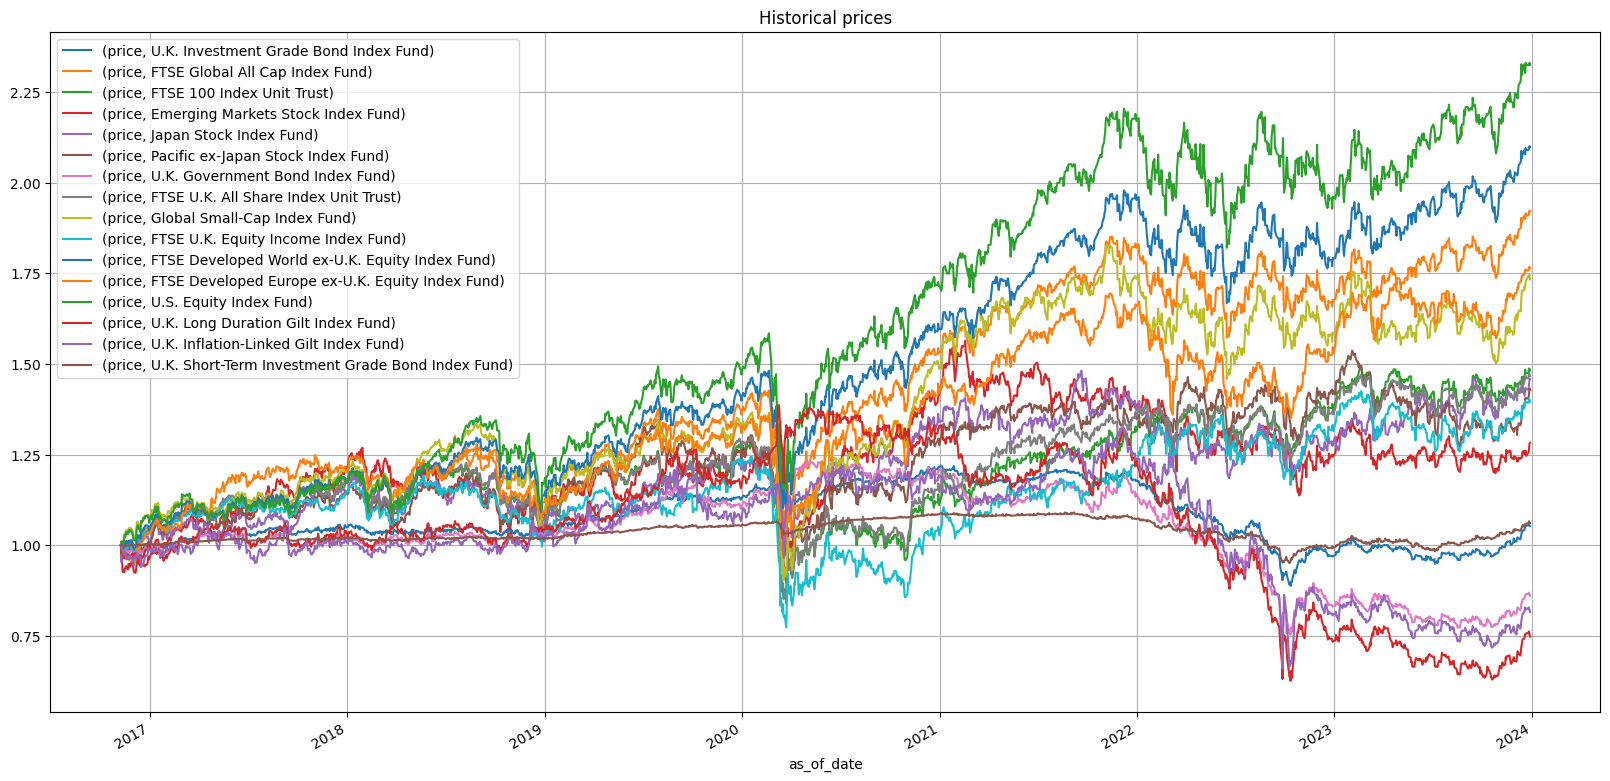

In [144]:
ax = (
    pivoted_prices.dropna(how="any")
    .div(pivoted_prices.dropna(how="any").iloc[0], axis=1)[sorted_sedols]
    .rename(columns=port_id_to_name)
    .plot(figsize=(20, 10), title="Historical prices", grid=True)
)
_ = ax.legend(loc="upper left")

## Prepare optimization inputs

In [158]:
prwn = pivoted_returns.rename(columns=port_id_to_name)[lambda x: sorted(x.columns)]
covariance = prwn.cov().sort_index()[lambda x: sorted(x.columns)]
expected_returns = prwn.mean()

In [159]:
class ProblemVariables:
    def __init__(self, expected_returns, covariance):

        assert (expected_returns.index == covariance.index).all()
        self.index = expected_returns.index
        er = expected_returns.to_numpy()
        cov = np.asmatrix(covariance.to_numpy())
        self.x = cp.Variable(len(expected_returns))
        self.vol = cp.quad_form(self.x, np.asmatrix(cov))
        self.ret = er.T @ self.x

    def results(self):
        return self.ret.value, self.std()

    def std(self):
        return np.sqrt(self.vol.value)

    def year_std(self):
        return self.std() * np.sqrt(252)

    def year_return(self):
        return (1 + self.ret.value) ** 252 - 1

    def full_results(self):
        results = dict(zip(self.index, self.x.value))
        results["return"] = self.year_return()
        results["std"] = self.year_std()
        return pd.Series(results)

    def maximize_returns(self):
        cp.Problem(cp.Maximize(self.ret), [sum(self.x) == 1, self.x >= 0]).solve(
            solver="CVXOPT"
        )
        return self

    def minimize_std(self):
        cp.Problem(cp.Minimize(self.vol), [sum(self.x) == 1, self.x >= 0]).solve(
            solver="CVXOPT"
        )
        return self

    def solve_for_std(self, std_limit):
        cp.Problem(
            cp.Maximize(self.ret),
            [
                self.vol <= std_limit**2,
                cp.sum(self.x) == 1,
                self.x >= 0,
            ],
        ).solve(solver="CVXOPT")
        return self

    def iterate_stds(self, points):
        min_std = self.minimize_std().std()
        max_std = self.maximize_returns().std()

        std_values = np.linspace(min_std, max_std, points)
        results = []
        for std_limit in std_values:
            results.append(self.solve_for_std(std_limit).full_results())
        return pd.DataFrame(results)

    def solve_for_return(self, return_limit):
        prob = cp.Problem(
            cp.Minimize(self.vol),
            [
                self.ret >= return_limit,
                cp.sum(self.x) == 1,
                self.x >= 0,
            ],
        ).solve(solver="CVXOPT")
        return self

    def iterate_returns(self, points):
        min_return = self.minimize_std().ret.value
        max_return = self.maximize_returns().ret.value

        return_values = np.linspace(min_return, max_return, points)

        results = []
        for return_value in return_values:
            results.append(self.solve_for_return(return_value).full_results())
        return pd.DataFrame(results)


std_ptfs = (
    ProblemVariables(expected_returns, covariance).minimize_std().iterate_stds(200)
)

## Plot results

In [160]:
def renormalize(df):
    row_sum = df.sum(axis=1)
    return df.div(row_sum, axis=0)


def plot_ptfs(ptfs, products_df, key="std"):
    assert key in ("std", "return")
    mapping = products_df.set_index("sedol")["name"].to_dict()

    return (
        ptfs.drop(columns=["return" if key == "std" else "std"])
        .set_index("std" if key == "std" else "return")
        .mask(lambda x: x < 0.01)
        .fillna(0)
        .loc[:, lambda x: (x != 0).any(axis=0)]
        .pipe(renormalize)
        .rename(columns=mapping)
        .plot.area(figsize=[20, 10], grid=True, legend="reverse")
    )

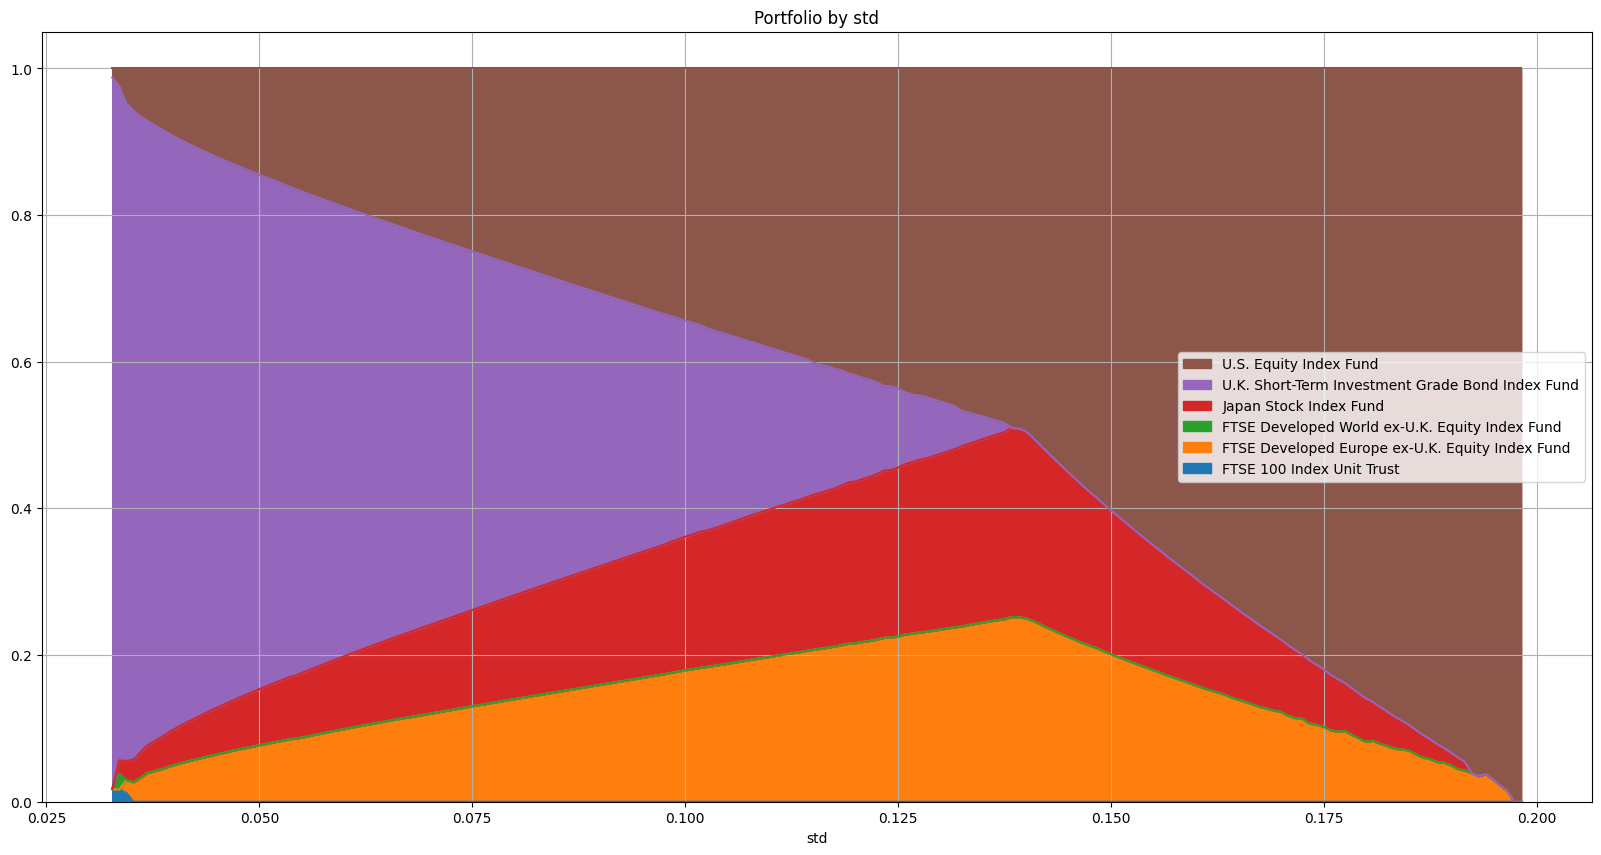

In [161]:
_ = plot_ptfs(std_ptfs, products_df, key="std").set_title("Portfolio by std")

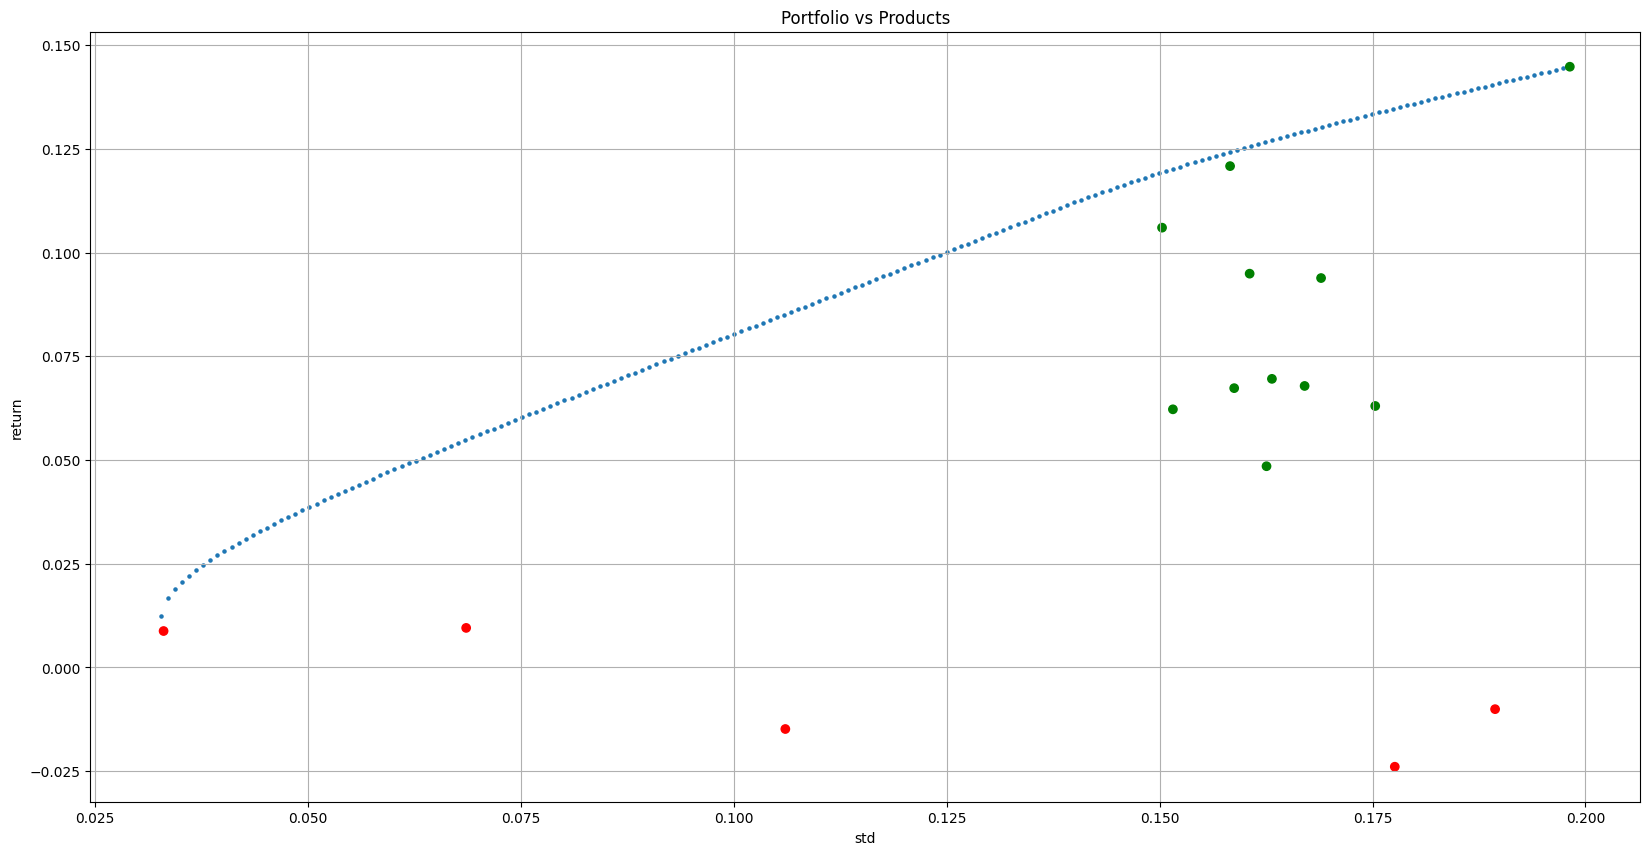

In [163]:
ax = std_ptfs.plot.scatter(x="std", y="return", grid=True, marker=".", figsize=(20, 10))
ax.scatter(
    x=products_stats_df["yearly_return_std"],
    y=products_stats_df["yearly_return_mean"],
    c=products_stats_df["asset_class"].map(ASSET_COLOURS),
)
_ = ax.set_title("Portfolio vs Products")

# Appendix 1: identifying redundant products

In [165]:
marginal_vifs = (
    pd.Series(
        [
            variance_inflation_factor(pivoted_returns.values, i)
            for i in range(len(pivoted_returns.columns))
        ],
        index=pivoted_returns.columns,
    )
    .sort_values()
    .rename("vif")
    .to_frame()
    .join(products_df.set_index("port_id")[["name"]])
)
marginal_vifs

,vif,name
port_id,,
9247,1.658663,U.K. Short-Term Investment Grade Bond Index Fund
9146,3.481148,Pacific ex-Japan Stock Index Fund
9125,3.481596,U.K. Investment Grade Bond Index Fund
9226,3.518880,U.K. Inflation-Linked Gilt Index Fund
9144,5.155828,Japan Stock Index Fund
9206,7.269323,FTSE U.K. Equity Income Index Fund
9140,7.471941,Emerging Markets Stock Index Fund
9156,9.883783,FTSE U.K. All Share Index Unit Trust
8619,11.326682,FTSE 100 Index Unit Trust


In [166]:
def calculate_vifs(pr):
    removed = {}
    for i in range(len(pr.columns) - 1):
        vif = (
            pd.Series(
                [
                    variance_inflation_factor(pr.values, i)
                    for i in range(len(pr.columns))
                ],
                index=pr.columns,
            )
            .sort_values()
            .rename("vif")
        )
        removed[vif.index[-1]] = vif.iloc[-1]

        pr = pr[lambda x: [c for c in x.columns if c not in removed]]
    removed[pr.columns[0]] = 1
    return pd.Series(removed, name="vif").sort_values()


recursive_vifs = (
    calculate_vifs(pivoted_returns)
    .to_frame()
    .rename_axis("port_id")
    .join(products_df.set_index("port_id")[["name"]])
)
recursive_vifs

,vif,name
port_id,,
9206,1.000000,FTSE U.K. Equity Income Index Fund
9226,1.005179,U.K. Inflation-Linked Gilt Index Fund
9144,1.021351,Japan Stock Index Fund
9218,1.248441,U.S. Equity Index Fund
9247,1.266706,U.K. Short-Term Investment Grade Bond Index Fund
9140,1.638211,Emerging Markets Stock Index Fund
9125,2.189931,U.K. Investment Grade Bond Index Fund
9146,2.611959,Pacific ex-Japan Stock Index Fund
9214,2.921922,FTSE Developed Europe ex-U.K. Equity Index Fund


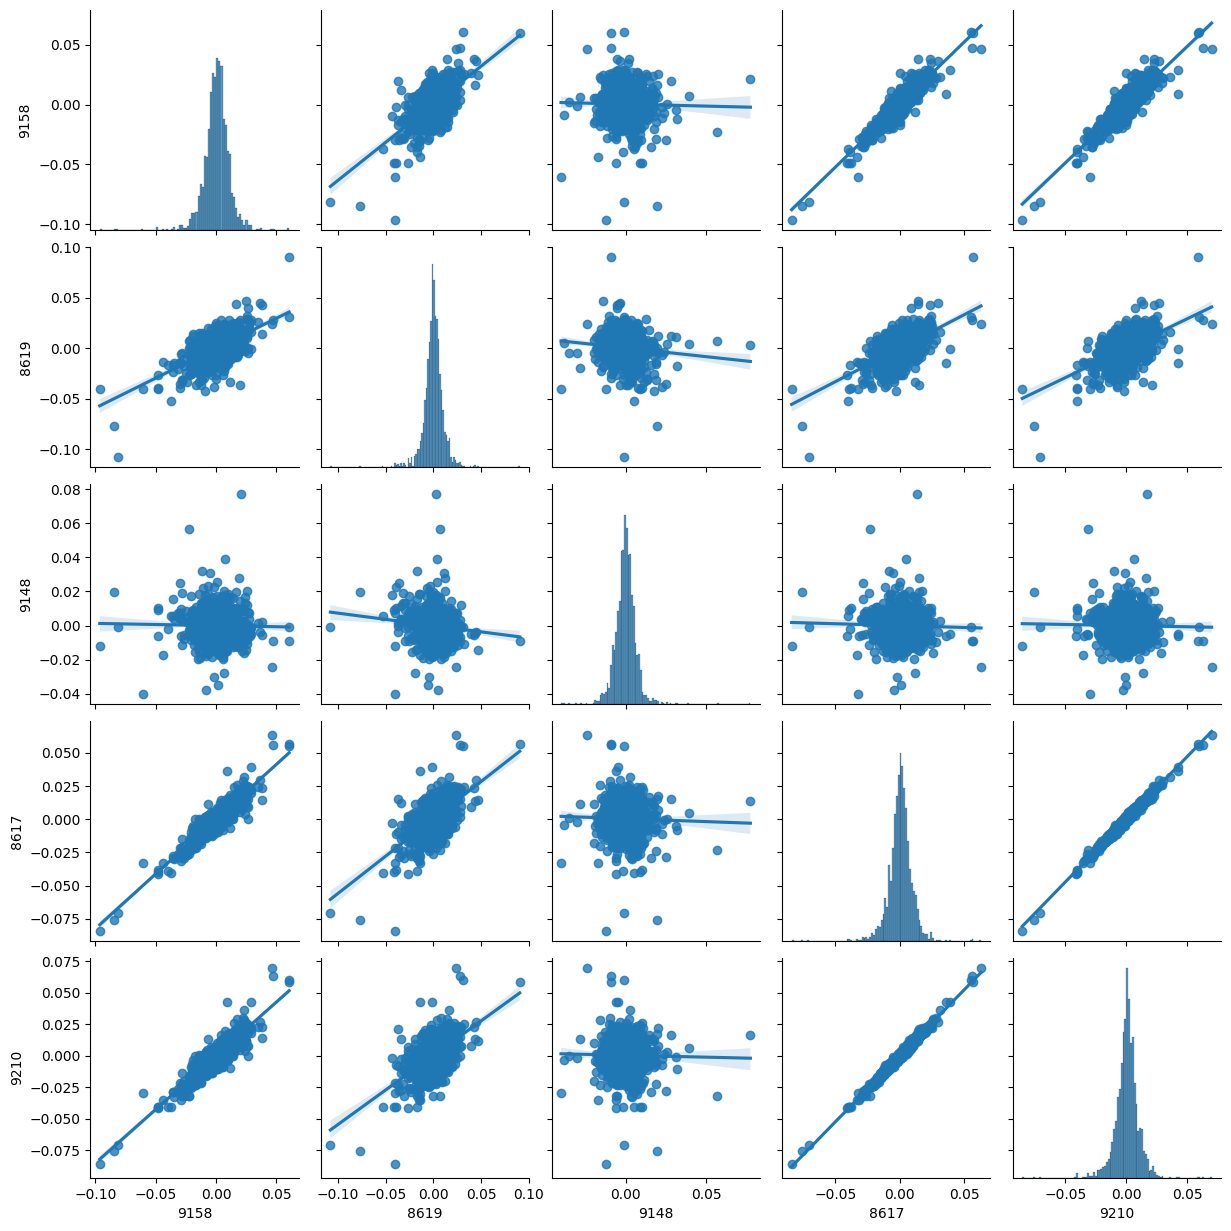

In [167]:
_ = sns.pairplot(pivoted_returns[recursive_vifs.index[-5:]], kind="reg")

# Appendix 2: Heat Map

In [ ]:
correlation = (
    pivoted_returns.rename(columns=products_df.set_index("sedol")["name"].to_dict())
    .rename_axis("product_name", axis=1)
    .corr()
    .sort_index()[lambda x: sorted(x.columns)]
)
fig, ax = plt.subplots(figsize=(10, 10))
_ = sns.heatmap(correlation, ax=ax)

# Appendix 3: PCA

In [172]:
from sklearn.decomposition import PCA

returns_by_name = pivoted_returns.rename(
    columns=products_df.set_index("port_id")["name"].to_dict()
)

components_number = 5
pca = PCA(n_components=components_number)
X = returns_by_name[lambda x: ~x.isnull().any(axis=1)].to_numpy().T
X = X / X.std()
components = pca.fit_transform(X)
principal_df = pd.DataFrame(
    data=components, columns=[str(i + 1) for i in range(0, components_number)]
)
principal_df.set_index(returns_by_name.columns).reset_index()

,port_id,1,2,3,4,5
0,FTSE Global All Cap Index Fund,-16.755187,14.794877,-4.635656,0.424963,0.047814
1,FTSE 100 Index Unit Trust,-18.357839,-21.919277,-5.950469,-2.386137,-2.050875
2,U.K. Investment Grade Bond Index Fund,20.809377,-2.682866,1.596735,-4.175725,12.569836
3,Emerging Markets Stock Index Fund,-9.796150,3.055063,20.892159,21.144209,3.885656
4,Japan Stock Index Fund,6.083897,8.134210,34.375507,-18.659720,-10.397983
5,Pacific ex-Japan Stock Index Fund,-6.662032,-2.090633,21.608683,11.273594,-1.199433
6,U.K. Government Bond Index Fund,31.745066,-0.191435,-3.326714,-1.879534,6.459967
7,FTSE U.K. All Share Index Unit Trust,-17.019713,-20.995058,-6.058240,-1.826125,-1.233316
8,Global Small-Cap Index Fund,-19.026691,13.720122,-7.825515,-1.687352,-2.835398
9,FTSE U.K. Equity Income Index Fund,-19.976697,-24.816039,-6.174568,-2.288244,-1.608497


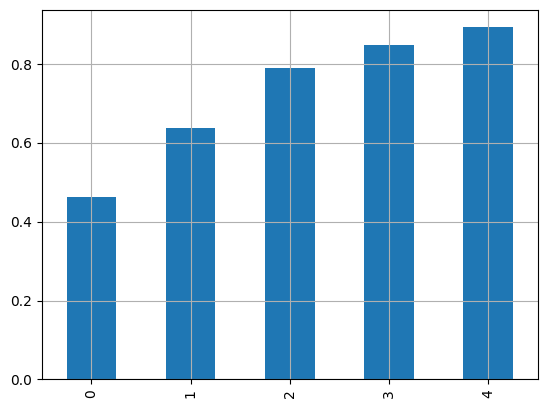

In [173]:
_ = pd.Series(pca.explained_variance_ratio_).cumsum().plot.bar(grid=True)